# Cross-validation of DeeSse simulations

We have a synthetic dataset with 100 facies observations (encoded 0 or 1). We are going to use cross-validation approach to find the most suitable training image among three candidate TIs (we will call them A, B, C). We will also identify the what number of nearest neighbors should be used in order to get a best match with the data.

We will use 5-fold cross-validation as implemented in the scikit-learn library. DeesseClassifier class has been implemented in a way that it is a valid classifier object and can be supplied to model_selection tools of scikit-learn. Quadratic scoring rule is also implemented in the geone package. We are going to use 5-fold stratified cross-validation with data shuffling and grid search cross-validation to check all combinations of parameters.

In [155]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.dummy import DummyClassifier

from geone.img import readImageGslib, sampleFromImage, writePointSetGslib, writeImageGslib, imageToPointSet
from geone.gslib import read
from geone.imgplot import drawImage2D
from geone.deesseinterface import DeesseClassifier, DeesseRegressor
from geone.cv_metrics import brier_score, zero_one_score, balanced_linear_score, SkillScore, crps

In [2]:
DATA_DIR = 'cv_data/'

## Observations

We have a classical gslib file with a point set and facies observations. We can load it to a dictionary of arrays, and then conveniently to a pandas dataframe.

In [3]:
# read file to a dictionary of arrays
observations = read(DATA_DIR+'sample_100.gslib')

# and pass it directly to DataFrame constructor
df_observations = pd.DataFrame(observations)
df_observations.head()

,X,Y,Z,code_real00000
0,41.5,51.5,0.5,0.0
1,80.5,92.5,0.5,0.0
2,62.5,61.5,0.5,0.0
3,60.5,26.5,0.5,0.0
4,50.5,10.5,0.5,0.0


In [4]:
# we can check basic stats of the point set
df_observations.describe()

,X,Y,Z,code_real00000
count,100.000000,100.000000,100.0,100.000000
mean,49.510000,49.960000,0.5,0.280000
std,29.644866,30.328977,0.0,0.451261
min,2.500000,1.500000,0.5,0.000000
25%,23.000000,19.250000,0.5,0.000000
50%,53.000000,51.000000,0.5,0.000000
75%,72.500000,76.500000,0.5,1.000000
max,98.500000,97.500000,0.5,1.000000


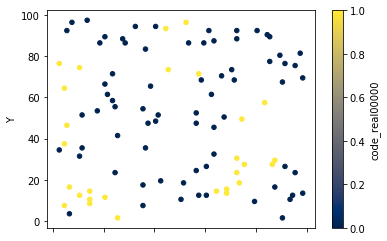

In [5]:
# quick plot of the set
df_observations.plot.scatter(x='X', y='Y', c='code_real00000', cmap='cividis')

## DeeSse simulation engine

We want to test what DeeSse parameters (including the TI) fit the best our observation set.

In [6]:
# Load training images using geone
ti_A = readImageGslib(DATA_DIR+'A.gslib')
ti_B = readImageGslib(DATA_DIR+'B.gslib')
ti_C = readImageGslib(DATA_DIR+'C.gslib')

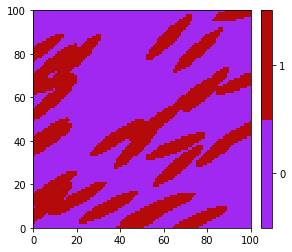

In [7]:
# draw training images using geone
drawImage2D(ti_A, categ=True)

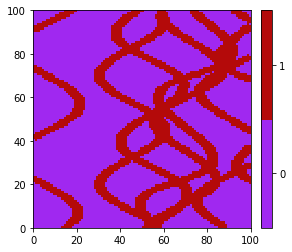

In [8]:
drawImage2D(ti_B, categ=True)

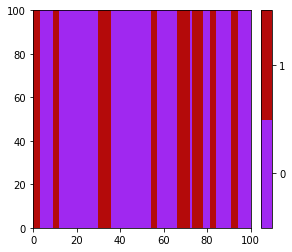

In [9]:
drawImage2D(ti_C, categ=True)

We need to set up DeesseClassifier. It takes the same arguements as DeesseInput plus varnames, which denotes variable names which will be attached to the observation set. Each column should have a name (including coordinates). In our case we have X,Y,Z and 'facies'. 'facies' is also the simulated variable. Note that the names which were read to the pandas DataFrame in the previous step do not matter, as only the values are passed to the simulation engine. Therefore we need to attach names to them to have them properly converted (internally) to a conditioning set.

In [10]:
# Define the interface for the DeeSse simulation tool
deesse_classifier = DeesseClassifier(
    varnames = ['X','Y','Z', 'facies'],
        nx=100, ny=100, nz=1,     # dimension of the simulation grid (number of cells)
        sx=1.0, sy=1.0, sz=1.0,   # cells units in the simulation grid (here are the default values)
        ox=0.0, oy=0.0, oz=0.0,   # origin of the simulation grid (here are the default values)
        nv=1, varname='facies',   # number of variable(s), name of the variable(s)
        nTI=1, TI=ti_A,           # number of TI(s), TI (class dsi.Img)
        distanceType=0,           # distance type: proportion of mismatching nodes (categorical var., default)
        nneighboringNode=20,      # max. number of neighbors (for the patterns)
        distanceThreshold=0.1,    # acceptation threshold (for distance between patterns)
        maxScanFraction=0.25,     # max. scanned fraction of the TI (for simulation of each cell)
        npostProcessingPathMax=1, # number of post-processing path(s)
        seed=20191201,            # seed (initialization of the random number generator)
        nrealization=4,           # number of realization(s)
        nthreads=4)               # number of threads to use for simulations

We can check if we properly defined the classifier by running simulate() method

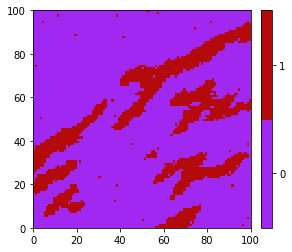

In [11]:
# run DeeSse and plot results
sim = deesse_classifier.simulate()
drawImage2D(sim['sim'][0], categ=True)

## Cross-validation engine

Now we are going to set-up cross validation. We will use scorers implemented in geone.cv_metrics module. Then, we will use GridSearchCV method of scikit-learn to evaluate all parameters combinations. We want to make sure that we use stratified cross-validation with data shuffling, therefore we are going to specify explicitly the split (again, by means of scikit-learn's splitter object).

Note that we could also use different model_selection tools available form scikit-learn, such as cross_validate, etc.

### Scoring functions

Scoring functions are implemented in geone. One could also define custom scorers or use functions from scikit-learn but the are not really suitable for probabilistic forecasts.

In [12]:
# use Brier score (quadratic score), zero-one score, balanced linear score
# and quadratic skill, zero-one skill scores
scoring = {
    'brier':brier_score,
    'zero_one':zero_one_score,
    'linear':balanced_linear_score,
    'skill_brier':SkillScore(DummyClassifier(strategy='prior'), 0, brier_score),
    'skill_zero_one':SkillScore(DummyClassifier(strategy='prior'), 1, zero_one_score),
}

### Splitter definition

We want to use 5-fold stratified cross-validation on randomly shuffled data. We use splitter implemented in scikit-learn package.

In [13]:
# Stratified 5-fold cross-validation with randomly shuffled data
cv = StratifiedKFold(n_splits=5,
                     shuffle=True,
                     random_state=20191201,
                    )


### Model selection tool

We are going to evaluate different sets of parameters, therefore it is convenient to use scikit learns's GridSearchCV.

In [14]:
# evaluate 3 training images and 3 different numbers of neighbors
# cross_validator will need to run 9 times DeeSse (simulating nrealizations every time)
cross_validator =  GridSearchCV(deesse_classifier,
                    param_grid={'TI': [ti_A, ti_B, ti_C],
                               'nneighboringNode': [5, 10, 15]},
                    scoring=scoring,
                    n_jobs=1,
                    cv=cv,
                    refit=False,
                    verbose=0,
                    error_score='raise',
                    return_train_score=False,
                   )

In [15]:
# run the cross-validation with our observed data
cross_validator.fit(X=df_observations[['X', 'Y', 'Z']],
                    y=df_observations['code_real00000'])

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=20191201, shuffle=True),
             error_score='raise',
             estimator=<geone.deesseinterface.DeesseClassifier object at 0x7f30cb614a58>,
             iid='deprecated', n_jobs=1,
             param_grid={'TI': [<geone.img.Img object at 0x7f30cca879b0>,
                         'nneighboringNode':...
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring={'brier': <function brier_score at 0x7f30cf6fcf28>,
                      'linear': <function balanced_linear_score at 0x7f30cf6d8e18>,
                      'skill_brier': <geone.cv_metrics.SkillScore object at 0x7f30cca87198>,
                      'skill_zero_one': <geone.cv_metrics.SkillScore object at 0x7f30cb5be5f8>,
                      'zero_one': <function zero_one_score at 0x7f30cf6d8b70>},
             verbose=0)

In [16]:
# get the results as pandas DataFrame
results = pd.DataFrame(cross_validator.cv_results_)
results.head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_TI,param_nneighboringNode,params,split0_test_brier,split1_test_brier,split2_test_brier,...,std_test_skill_brier,rank_test_skill_brier,split0_test_skill_zero_one,split1_test_skill_zero_one,split2_test_skill_zero_one,split3_test_skill_zero_one,split4_test_skill_zero_one,mean_test_skill_zero_one,std_test_skill_zero_one,rank_test_skill_zero_one
0,0.001230,0.000041,0.061188,0.001001,cv_data/A.gslib,5,"{'TI': cv_data/A.gslib, 'nneighboringNode': 5}",-0.28750,-0.40000,-0.61875,...,0.371248,6,0.0,-0.1,-0.333333,0.416667,0.666667,0.130000,0.361847,3
1,0.001215,0.000016,0.060722,0.001009,cv_data/A.gslib,10,"{'TI': cv_data/A.gslib, 'nneighboringNode': 10}",-0.24375,-0.36250,-0.61875,...,0.308923,7,0.2,0.1,-0.333333,0.250000,0.250000,0.093333,0.220252,7
2,0.001214,0.000011,0.097480,0.004293,cv_data/A.gslib,15,"{'TI': cv_data/A.gslib, 'nneighboringNode': 15}",-0.16250,-0.33125,-0.48125,...,0.315579,1,0.5,0.0,0.000000,0.333333,0.833333,0.333333,0.316228,1
3,0.001211,0.000007,0.057123,0.000587,cv_data/B.gslib,5,"{'TI': cv_data/B.gslib, 'nneighboringNode': 5}",-0.32500,-0.38125,-0.66250,...,0.309179,8,0.1,-0.2,-0.583333,-0.083333,0.250000,-0.103333,0.285073,9
4,0.001361,0.000270,0.063233,0.001237,cv_data/B.gslib,10,"{'TI': cv_data/B.gslib, 'nneighboringNode': 10}",-0.22500,-0.36250,-0.45000,...,0.161626,4,0.4,-0.1,0.000000,0.250000,0.083333,0.126667,0.178450,4


In [17]:
# show three best scores (Brier score)
features = ['param_TI', 'param_nneighboringNode',
            'mean_test_brier', 'mean_test_zero_one',
            'mean_test_linear', 'mean_test_skill_brier', 'mean_test_skill_zero_one']
results.sort_values(by='mean_test_brier', ascending=False).head(3)[features]

,param_TI,param_nneighboringNode,mean_test_brier,mean_test_zero_one,mean_test_linear,mean_test_skill_brier,mean_test_skill_zero_one
2,cv_data/A.gslib,15,-0.27375,0.815,0.688571,0.323197,0.333333
8,cv_data/C.gslib,15,-0.31250,0.800,0.678571,0.234961,0.293333
6,cv_data/C.gslib,5,-0.33500,0.750,0.645833,0.171655,0.106667


The training image A has a higher quadratic score and also zero-one score. Therefore, it is probably a more suitable training image for the problem at hand. It is also better to use a bigger number of neighboring nodes.

## Continuous cross-validation

Let's use a dataset with continuous values and try to identify the best DS parameters.

In [18]:
df_continuous_obs = pd.DataFrame(read(DATA_DIR+'continous_sample_100.gslib'))
df_continuous_obs.describe()

,X,Y,Z,facies_real00000
count,100.000000,100.000000,100.0,100.000000
mean,49.040000,51.590000,0.5,129.310000
std,27.568251,26.294023,0.0,59.952455
min,4.500000,5.500000,0.5,3.000000
25%,23.250000,30.250000,0.5,97.750000
50%,49.000000,49.000000,0.5,154.500000
75%,74.000000,71.750000,0.5,170.250000
max,98.500000,99.500000,0.5,214.000000


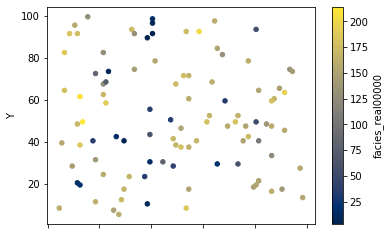

In [19]:
# quick plot
df_continuous_obs.plot.scatter(x='X', y='Y', c='facies_real00000', cmap='cividis')

We know in this case the corresponding TI.

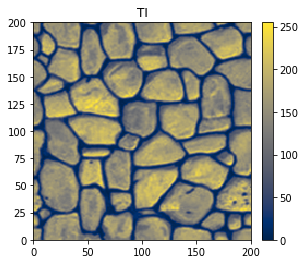

In [20]:
ti = readImageGslib('tiContinuous.gslib')
drawImage2D(ti, cmap='cividis', title='TI')

In [156]:
# Define the interface for the DeeSse simulation tool
deesse_regressor = DeesseRegressor(
    varnames = ['X','Y','Z', 'facies'],
        nx=100, ny=100, nz=1,     # dimension of the simulation grid (number of cells)
        sx=1.0, sy=1.0, sz=1.0,   # cells units in the simulation grid (here are the default values)
        ox=0.0, oy=0.0, oz=0.0,   # origin of the simulation grid (here are the default values)
        nv=1, varname='facies',   # number of variable(s), name of the variable(s)
        nTI=1, TI=ti,           # number of TI(s), TI (class dsi.Img)
        distanceType=1,           # distance type: proportion of mismatching nodes (categorical var., default)
        nneighboringNode=20,      # max. number of neighbors (for the patterns)
        distanceThreshold=0.1,    # acceptation threshold (for distance between patterns)
        maxScanFraction=0.5,     # max. scanned fraction of the TI (for simulation of each cell)
        npostProcessingPathMax=1, # number of post-processing path(s)
        seed=20200226,            # seed (initialization of the random number generator)
        nrealization=4,           # number of realization(s)
        nthreads=4)               # number of threads to use for simulations

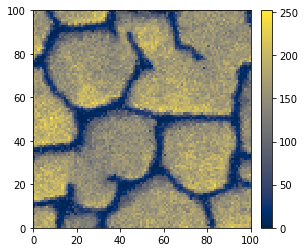

In [157]:
# show example simulation
sim = deesse_regressor.simulate()
drawImage2D(sim['sim'][0], cmap='cividis')

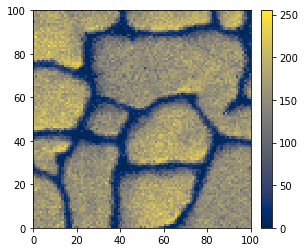

In [158]:
# we know the true field
true_field = readImageGslib(DATA_DIR+'continous_sim_100_100.gslib')
drawImage2D(true_field, cmap='cividis')

In [159]:
# And also all true points as "true" gslib
field_points = pd.DataFrame(read(DATA_DIR+'true_points.gslib'))
field_points.describe()

,X,Y,Z,facies_real00000
count,10000.000000,10000.000000,10000.0,10000.000000
mean,50.000000,50.000000,0.5,133.256500
std,28.867513,28.867513,0.0,57.254929
min,0.500000,0.500000,0.5,0.000000
25%,25.250000,25.250000,0.5,106.000000
50%,50.000000,50.000000,0.5,152.000000
75%,74.750000,74.750000,0.5,172.000000
max,99.500000,99.500000,0.5,255.000000


Simulation looks fine. Now, let's use CRPS and 5-fold cross-validation to check sensitivity to the number of realisations.

In [160]:
cross_validator =  GridSearchCV(deesse_regressor,
                    param_grid={'nrealization': range(1,50,3),
                                },
                    scoring=crps,
                    n_jobs=1,
                    cv= KFold(n_splits=5,
                     shuffle=True,
                     random_state=20191201,
                    ),
                    refit=False,
                    verbose=0,
                    error_score='raise',
                    return_train_score=False,
                   )

In [161]:
cross_validator.fit(df_continuous_obs[['X','Y','Z']], df_continuous_obs['facies_real00000'])

GridSearchCV(cv=KFold(n_splits=5, random_state=20191201, shuffle=True),
             error_score='raise',
             estimator=<geone.deesseinterface.DeesseRegressor object at 0x7f30bf597208>,
             iid='deprecated', n_jobs=1,
             param_grid={'nrealization': range(1, 50, 3)},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=<function crps at 0x7f30cf6fcea0>, verbose=0)

In [162]:
df_cv_results = pd.DataFrame(cross_validator.cv_results_)
df_cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nrealization,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001403,0.000138,0.199953,0.009512,1,{'nrealization': 1},41.850000,36.500000,30.200000,54.950000,36.000000,39.900000,8.380513,1
1,0.001359,0.000010,0.733535,0.039299,4,{'nrealization': 4},21.906250,28.734375,30.625000,27.403125,22.675000,26.268750,3.414366,2
2,0.001369,0.000004,1.289157,0.082488,7,{'nrealization': 7},23.357143,24.966327,30.777551,24.335714,21.119388,24.911224,3.210646,3
3,0.001693,0.000616,1.828186,0.069692,10,{'nrealization': 10},23.531500,21.478000,25.416000,24.650000,18.328000,22.680700,2.548582,4
4,0.001678,0.000588,2.364016,0.096444,13,{'nrealization': 13},24.081953,22.777219,25.138166,21.690533,18.574556,22.452485,2.262406,7


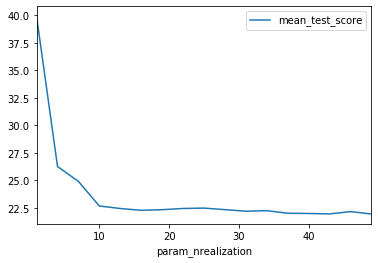

In [163]:
df_cv_results.plot(x='param_nrealization', y='mean_test_score')

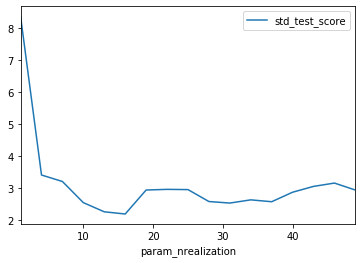

In [164]:
df_cv_results.plot(x='param_nrealization', y='std_test_score')

In [75]:
df_copy = df_continuous_obs.copy()

In [78]:
df_copy.index = pd.MultiIndex.from_arrays([df_copy['X'], df_copy['Y'], df_copy['Z']])

In [79]:
df_copy.head()

,,,X,Y,Z,facies_real00000
X,Y,Z,,,,
37.5,23.5,0.5,37.5,23.5,0.5,35.0
91.5,63.5,0.5,91.5,63.5,0.5,194.0
97.5,27.5,0.5,97.5,27.5,0.5,156.0
86.5,33.5,0.5,86.5,33.5,0.5,123.0
80.5,19.5,0.5,80.5,19.5,0.5,155.0


In [143]:
field_points_copy = field_points.copy()

In [144]:
field_points_copy.index = pd.MultiIndex.from_arrays([field_points_copy['X'], field_points_copy['Y'], field_points_copy['Z']])

In [145]:
field_points_copy['split'] = 0

In [146]:
field_points_copy.loc[field_points_copy.index.isin(df_copy.index), 'split'] = -1

/home/judap/source/geone/venv/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2848: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)


In [147]:
field_points_copy.describe()

,X,Y,Z,facies_real00000,split
count,10000.000000,10000.000000,10000.0,10000.000000,10000.000000
mean,50.000000,50.000000,0.5,133.256500,-0.010000
std,28.867513,28.867513,0.0,57.254929,0.099504
min,0.500000,0.500000,0.5,0.000000,-1.000000
25%,25.250000,25.250000,0.5,106.000000,0.000000
50%,50.000000,50.000000,0.5,152.000000,0.000000
75%,74.750000,74.750000,0.5,172.000000,0.000000
max,99.500000,99.500000,0.5,255.000000,0.000000


In [ ]:
deesse_regressor.fit(df_continuous_obs[['X','Y','Z']], df_continuous_obs['facies_real00000'])

In [148]:
from sklearn.model_selection import PredefinedSplit
ps = PredefinedSplit(field_points_copy['split'])

In [149]:
cross_validator_exact =  GridSearchCV(deesse_regressor,
                    param_grid={'nrealization': range(1,50,3),
                                },
                    scoring=crps,
                    n_jobs=1,
                    cv=ps,
                    refit=False,
                    verbose=0,
                    error_score='raise',
                    return_train_score=False,
                   )

In [150]:
cross_validator_exact.fit(field_points_copy[['X','Y','Z']], field_points_copy['facies_real00000'])

GridSearchCV(cv=PredefinedSplit(test_fold=array([0, 0, ..., 0, 0])),
             error_score='raise',
             estimator=<geone.deesseinterface.DeesseRegressor object at 0x7f30cb557be0>,
             iid='deprecated', n_jobs=1,
             param_grid={'nrealization': range(1, 50, 3)},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=<function crps at 0x7f30cf6fcea0>, verbose=0)

In [151]:
df_results2= pd.DataFrame(cross_validator_exact.cv_results_)
df_results2.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_nrealization,params,split0_test_score,mean_test_score,std_test_score,rank_test_score
0,0.001893,0.0,1.709891,0.0,1,{'nrealization': 1},44.184747,44.184747,0.0,1
1,0.001710,0.0,2.287654,0.0,4,{'nrealization': 4},28.050069,28.050069,0.0,2
2,0.001678,0.0,2.799456,0.0,7,{'nrealization': 7},26.588470,26.588470,0.0,3
3,0.001677,0.0,3.340667,0.0,10,{'nrealization': 10},25.413225,25.413225,0.0,4
4,0.001674,0.0,3.887204,0.0,13,{'nrealization': 13},24.676508,24.676508,0.0,5


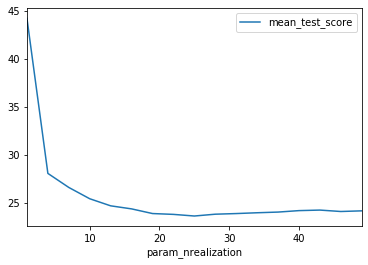

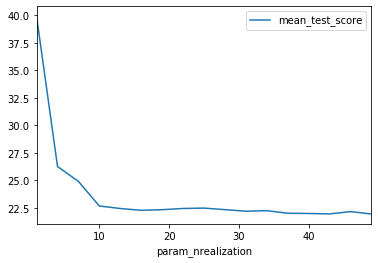

In [165]:
df_results2.plot(x='param_nrealization', y='mean_test_score')
df_cv_results.plot(x='param_nrealization', y='mean_test_score')